# Insurance Fraud Claims Detection

In this notebook, I'm going to train the model with engineered data and selected features.

## Libraries and Enviroments

In [1]:
#Read the data
import numpy as np 
import pandas as pd

# Data Sciences
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix
%matplotlib inline

#Utils
import os

# Set notebook
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.simplefilter(action='ignore')

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
raw = '../data/raw/insurance_claims.csv'
interim = '../data/interim/'
processed= '../data/processed/'
models= '../models/'

## Data Preparation

### Read Data

In [3]:
X_train = pd.read_csv(processed + 'X_train_final.csv')
X_test = pd.read_csv(processed + 'X_test_final.csv')
y_train = pd.read_csv(processed + 'y_train_imputed.csv')['y_train']
y_test =  pd.read_csv(processed + 'y_test_imputed.csv')['y_test']

### Load features

In [4]:
features_selected = pd.read_csv(processed + 'selected_features.csv', header=None, names=['features'])
features_selected = list(features_selected['features'])

print('Number of features: ', len(features_selected))
print('\n', sorted(features_selected))

Number of features:  13

 ['bodily_injuries', 'capital_gains', 'capital_loss', 'incident_hour_of_the_day', 'incident_severity', 'insured_hobbies_chess', 'insured_hobbies_cross-fit', 'insured_hobbies_others', 'policy_annual_premium_groups', 'policy_deductable_groups', 'total_claim_amount', 'umbrella_limit', 'witnesses']


In [5]:
X_train = X_train[features_selected]
X_test = X_test[features_selected]

### Smote for balancing

#### Target distribution

In [6]:
print(y_train.value_counts()/len(y_train), '\n')

0    0.74861
1    0.25139
Name: y_train, dtype: float64 



#### Smote for balancing

In [7]:
smote = SMOTE(random_state=9)
X_train, y_train = smote.fit_resample(X_train, y_train)

#### Syntetic Target distribution

In [8]:
print(y_train.value_counts()/len(y_train), '\n')

1    0.5
0    0.5
Name: y_train, dtype: float64 



## Model Building

In [9]:
model_predictions = {}

### Logistic regression


********************
**Model Assessment**
********************
score: 0.56

Classification report
              precision    recall  f1-score   support

           0       0.82      0.57      0.67        79
           1       0.24      0.52      0.33        21

    accuracy                           0.56       100
   macro avg       0.53      0.55      0.50       100
weighted avg       0.70      0.56      0.60       100


Confusion Matrix


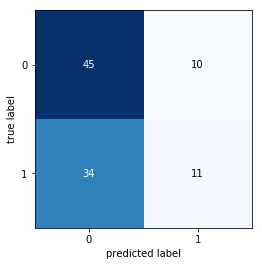

In [10]:
logit = LogisticRegression(random_state=8)

logit.fit(X_train, y_train)
predictions = logit.predict(X_test)

print()
print("*"*20)
print("Model Assessment".center(20, '*'))
print("*"*20)

predictions = logit.predict(X_test)
print('score: {}'.format(round(logit.score(X_test, y_test), 3)))
print()

print('Classification report')
print(classification_report(y_test, predictions))

print()

print('Confusion Matrix')
conf_matrix = confusion_matrix(predictions, y_test)
plot_confusion_matrix(conf_matrix);

tpr, fpr, threshold = roc_curve(predictions, y_test, pos_label=1)
model_predictions["Logistic Regression"] = [tpr, fpr]

### Support Vector Machine

********************
**Model Assessment**
********************
score: 0.75

Classification report
              precision    recall  f1-score   support

           0       0.90      0.77      0.83        79
           1       0.44      0.67      0.53        21

    accuracy                           0.75       100
   macro avg       0.67      0.72      0.68       100
weighted avg       0.80      0.75      0.77       100


Confusion Matrix


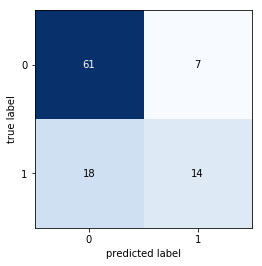

In [11]:
svc = SVC(random_state=8)

svc.fit(X_train, y_train)
predictions = svc.predict(X_test)

print("*"*20)
print("Model Assessment".center(20, '*'))
print("*"*20)

predictions = svc.predict(X_test)
print('score: {}'.format(round(svc.score(X_test, y_test), 3)))
print()

print('Classification report')
print(classification_report(y_test, predictions))

print()

print('Confusion Matrix')
conf_matrix = confusion_matrix(predictions, y_test)
plot_confusion_matrix(conf_matrix);

tpr, fpr, threshold = roc_curve(predictions, y_test, pos_label=1)
model_predictions["SVM"] = [tpr, fpr]

### Decision Tree

********************
**Model Assessment**
********************
score: 0.82

Classification report
              precision    recall  f1-score   support

           0       0.94      0.82      0.88        79
           1       0.55      0.81      0.65        21

    accuracy                           0.82       100
   macro avg       0.75      0.82      0.77       100
weighted avg       0.86      0.82      0.83       100


Confusion Matrix


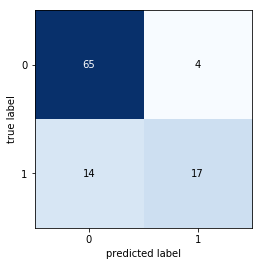

In [12]:
dtree = DecisionTreeClassifier(random_state=8)

dtree.fit(X_train, y_train)
predictions = dtree.predict(X_test)

print("*"*20)
print("Model Assessment".center(20, '*'))
print("*"*20)

predictions = dtree.predict(X_test)
print('score: {}'.format(round(dtree.score(X_test, y_test), 3)))
print()

print('Classification report')
print(classification_report(y_test, predictions))

print()

print('Confusion Matrix')
conf_matrix = confusion_matrix(predictions, y_test)
plot_confusion_matrix(conf_matrix);

tpr, fpr, threshold = roc_curve(predictions, y_test, pos_label=1)
model_predictions["Decision Tree"] = [tpr, fpr]

### Random Forest

********************
**Model Assessment**
********************
score: 0.84

Classification report
              precision    recall  f1-score   support

           0       0.93      0.86      0.89        79
           1       0.59      0.76      0.67        21

    accuracy                           0.84       100
   macro avg       0.76      0.81      0.78       100
weighted avg       0.86      0.84      0.85       100


Confusion Matrix


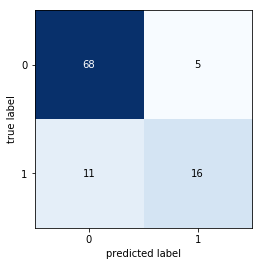

In [13]:
rfor = RandomForestClassifier(random_state=8)

rfor.fit(X_train, y_train)
predictions = rfor.predict(X_test)

print("*"*20)
print("Model Assessment".center(20, '*'))
print("*"*20)

print('score: {}'.format(round(rfor.score(X_test, y_test), 3)))
print()

print('Classification report')
print(classification_report(y_test, predictions))

print()

print('Confusion Matrix')
conf_matrix = confusion_matrix(predictions, y_test)
plot_confusion_matrix(conf_matrix);

tpr, fpr, threshold = roc_curve(predictions, y_test, pos_label=1)
model_predictions["Random Forest"] = [tpr, fpr]

### LightGB

********************
**Model Assessment**
********************
score: 0.84

Classification report
              precision    recall  f1-score   support

           0       0.93      0.86      0.89        79
           1       0.59      0.76      0.67        21

    accuracy                           0.84       100
   macro avg       0.76      0.81      0.78       100
weighted avg       0.86      0.84      0.85       100


Confusion Matrix


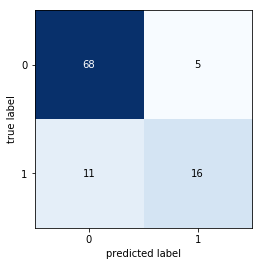

In [14]:
lgbm = LGBMClassifier(random_state=8)

lgbm.fit(X_train, y_train)
predictions = lgbm.predict(X_test)

print("*"*20)
print("Model Assessment".center(20, '*'))
print("*"*20)

predictions = lgbm.predict(X_test)
print('score: {}'.format(round(lgbm.score(X_test, y_test), 3)))
print()

print('Classification report')
print(classification_report(y_test, predictions))

print()

print('Confusion Matrix')
conf_matrix = confusion_matrix(predictions, y_test)
plot_confusion_matrix(conf_matrix);

tpr, fpr, threshold = roc_curve(predictions, y_test, pos_label=1)
model_predictions["LightGBM"] = [tpr, fpr]

## Model Assessment

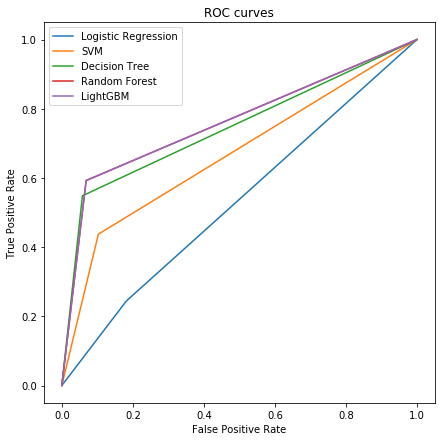

In [15]:
plt.figure(figsize=(7,7))
plt.title("ROC curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

for key, value in model_predictions.items():
    model_list = model_predictions[key]
    plt.plot(model_list[0], model_list[1], label=key)
    plt.legend()
plt.show()

## Model Tuning

In [16]:
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyper = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

grid = GridSearchCV(rfor, hyper, cv = 3, verbose = 1, n_jobs = -1)
best = grid.fit(X_train, y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  5.1min finished


In [17]:
best.best_estimator_

RandomForestClassifier(max_depth=25, n_estimators=800, random_state=8)

********************
**Model Assessment**
********************
score: 0.85

Classification report
              precision    recall  f1-score   support

           0       0.94      0.86      0.90        79
           1       0.61      0.81      0.69        21

    accuracy                           0.85       100
   macro avg       0.78      0.84      0.80       100
weighted avg       0.87      0.85      0.86       100


Confusion Matrix


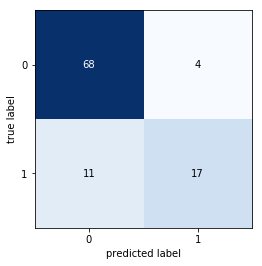

In [18]:
rfor_tune = RandomForestClassifier(max_depth=25, min_samples_split=5, n_estimators=300,
                       random_state=8)

rfor_tune.fit(X_train, y_train)
predictions = rfor_tune.predict(X_test)

print("*"*20)
print("Model Assessment".center(20, '*'))
print("*"*20)

predictions = rfor_tune.predict(X_test)
print('score: {}'.format(round(rfor_tune.score(X_test, y_test), 3)))
print()

print('Classification report')
print(classification_report(y_test, predictions))

print()

print('Confusion Matrix')
conf_matrix = confusion_matrix(predictions, y_test)
plot_confusion_matrix(conf_matrix);

tpr, fpr, threshold = roc_curve(predictions, y_test, pos_label=1)
model_predictions["Random Forest Tuned"] = [tpr, fpr]

## Conclusion

The best model is the **Random Forest** with a score of **0.85**